<font color = red><b> To do list </b> </font>
<br>
[ ] Decision tree

Import Packages<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import chi2
print ("Leo_test")

Leo_test


Parameter setting
1. Folder path
2. Metadat

In [2]:
root_folder = 'HM1/'
train_file = 'train.csv'
test_file = 'test.csv'
Index = 'TransactionID'
Target = 'isFraud'

Read data

In [40]:
train = pd.read_csv(root_folder + train_file)
test = pd.read_csv(root_folder + test_file)
#print (train.columns)
train.shape

(472432, 27)

In [29]:
52428/train.shape[0]

0.1109747011210079

Basic statistics

In [143]:
size = train.shape
Columns = train.columns.values
Columns = Columns[Columns != Index]
Categoric_features = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2']
Numeric_features = np.setdiff1d(Columns, Categoric_features)
MissingData = pd.DataFrame(index = Columns)
for i in Columns:
  #fig, ax  = plt.subplots(figsize= (5,3))
  #plt.hist(train[i])
  # if i in Numeric_features:
  #       identify = 'Numeric'
  # else:
  #   identify = 'Categoric'
  # plt.title(f"{i:}, {identify}")
  # if i == 'isFraud':
  #       continue
  tmp_df = train[(train[i]=='NotFound') | (train[i].isna())] #test[(test[i]=='NotFound') | (test[i].isna())]
  MissingData.loc[i,0] = tmp_df.shape[0]
Categoric_features.append('Num_Cat')
print (Numeric_features)
print (Categoric_features)
MissingData

['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'TransactionAmt' 'TransactionDT' 'isFraud']
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Num_Cat']


,0
ProductCD,0.0
card1,0.0
card2,7203.0
card3,1258.0
card4,1269.0
card5,3404.0
card6,1261.0
addr1,52428.0
addr2,52428.0
TransactionDT,0.0


Dealing with missing data in <font color = 'red'> <b>train phase </font>

In [77]:
############# 1. remove missing records ############
train_filter = train.copy() 
############# 1. remove missing records ############


############# 2. Use most frequency values ############
train_Impu = train.copy() 
#test_Impu = test.copy()
############# 2. Use most frequency values ############

for i in tqdm(Columns):
  train_filter = train_filter[train_filter[i]!='NotFound']
  train_Impu.loc[train_Impu[i]=='NotFound',i] = train_Impu[i].value_counts().idxmax()
  # if i != 'isFraud':
  #   test_Impu[test_Impu[i]=='NotFound'] = test[i].value_counts().idxmax()
print (train_filter.shape[0]/size[0])


100%|██████████| 26/26 [00:02<00:00, 11.33it/s]

0.871657720052833


Information gain function

In [75]:
3 == 1 or 3

3

In [112]:
def Info_Gain(Input_Dataframe, Split_feature, IG_methods, Num_Cat): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'

  #print (Input_Dataframe)
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  #print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = float(len(Fraud_arr[Fraud_arr == 1])/length)
  #print (Fraud_arr)
  #print ("P_F = ", P_isF)
  P_notF = 1-P_isF
  Impu_root = 0
  Impu_leaves = [] #Impurity of each leaves
  Prop_leaves = [] #Propotion of each leaves
  IG_feature_Num = [] #IGs for numeric features
  #print ('Pass line 10')
  if Num_Cat == 'Cat' or Num_Cat == 'Mid':
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    #print ("FC = " , Feature_classes)
    if IG_methods == 'Gini':
      Impu_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
      #print ("Impu_root:", Impu_root)
      #print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Impu_leaves.append(1 - Sub_P_isF ** 2  - Sub_P_notF ** 2)
        Prop_leaves.append(Sub_len/length)
    elif IG_methods == 'MisEr':
      Impu_root = 1 - max(P_isF,P_notF)
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Impu_leaves.append(1 - max(Sub_P_isF,Sub_P_notF))
        Prop_leaves.append(Sub_len/length)
    elif IG_methods == 'Entropy':
      if P_isF == 0:
        Ent_P_isF = 0
      else:
        Ent_P_isF = P_isF * np.log2(P_isF)
      if P_notF == 0:
        Ent_P_notF = 0
      else:
        Ent_P_notF = P_notF * np.log2(P_notF)
      Impu_root = -(Ent_P_notF + Ent_P_isF)
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        if Sub_P_isF == 0:
          Ent_Sub_P_isF = 0
        else:
          Ent_Sub_P_isF = Sub_P_isF * np.log2(Sub_P_isF)
        if Sub_P_notF == 0:
          Ent_sub_P_isF = 0
        else:
          Ent_Sub_P_not_F = Sub_P_notF * np.log2(Sub_P_notF)
        Impu_leaves.append(-(Ent_Sub_P_isF + Ent_Sub_P_not_F))
        Prop_leaves.append(Sub_len/length)
    
  elif Num_Cat == 'Num':
    Sort_Input = np.unique(Input_Dataframe[Split_feature])
    Sort_Input = Sort_Input.astype(np.float32)
    #print (Sort_Input)    
    for i in tqdm(Sort_Input):
      tmp_Input_Dataframe = Input_Dataframe.copy()
      #print ("i = ", i)
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] <= i,Split_feature] = 0
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] > i,Split_feature] = 1
      #print (tmp_Input_Dataframe)
      IG_feature_Num.append(Info_Gain(tmp_Input_Dataframe,Split_feature, IG_methods, 'Mid'))
      #return Info_Gain(tmp_Input_Dataframe,'Num_Cat', IG_methods)
    
    #return IG_feature_Num

  Impu_root = np.array(Impu_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature =  float(f"{Impu_root - np.matmul(Impu_leaves,Prop_leaves.T):.5f}")
  #print (IG_feature)
  #print (Impu_root)
  #print (Impu_leaves)
  #print (Prop_leaves)
  
  if Num_Cat == 'Num':
    #print (IG_feature_Num)
    IG_feature = max(IG_feature_Num)
    return [IG_feature, Sort_Input[IG_feature_Num.index(IG_feature)]] 
  elif Num_Cat == 'Mid':
    #print (IG_feature)
    return IG_feature
  elif Num_Cat == 'Cat':
    return [IG_feature, -3.1415926] # -pi means it is a categorical feature
  

Chi-Square 

In [223]:
def Chi_test(Input_Dataframe, Split_feature, *Split_pts_Num):
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  #print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = float(len(Fraud_arr[Fraud_arr == 1])/length)
  #print (P_isF)
  P_notF = 1-P_isF
  if (P_isF == 1) or (P_notF == 1):
    return 0
  Chi_sq = 0
  alpha = 0.05
  #print (Split_feature)
  if Split_feature in Categoric_features:
    #print ('in')
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    #print (Feature_classes)
    Degree_Freedom = (len(Feature_classes) - 1) * (2-1) # 2: T/F in isFraud
    #print (Degree_Freedom)
    for i in Feature_classes:
      Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
      #print (Sub_df)
      Sub_len = len(Sub_df)
      Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
      #print (Sub_P_isF)
      Sub_P_notF = 1-Sub_P_isF
      Chi_sq = Chi_sq + Sub_len * ((Sub_P_isF - P_isF)**2/P_isF + (Sub_P_notF - P_notF)**2/P_notF)
    Chi_basic = chi2.ppf(1 - alpha, Degree_Freedom)
    
  elif Split_feature in Numeric_features:
    Degree_Freedom = 1*1
    tmp_Input_Dataframe = Input_Dataframe.copy()
    #print (tmp_Input_Dataframe)
    #print (Split_pts_Num)
    Split_pts_Num = Split_pts_Num[0]
    #tmp_Input_Dataframe[Split_feature] < 2
    tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] <= Split_pts_Num,'Num_Cat'] = 0
    tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] > Split_pts_Num,'Num_Cat'] = 1
    Chi_sq = Chi_test(tmp_Input_Dataframe,'Num_Cat')
    Chi_basic = chi2.ppf(1 - alpha, Degree_Freedom)
  
  if Split_feature != 'Num_Cat':
    if Chi_sq > Chi_basic:
      print (Chi_sq, Chi_basic)
      return 1  # good result, expanding
    else:
      print (Chi_sq, Chi_basic)
      return 0  # bad result, not expanding
  if Split_feature == 'Num_Cat':
      return Chi_sq


In [158]:
Chi_test(test,'C1',25)
#Chi_test(test,'ProductCD')

10.0 3.841458820694124


1

Build one DT

In [240]:
class TreeNode:
    # Self_Column: feature
    # Sub_branches: line connecting two nodes
    def __init__(self, Self_Column = None, Sub_branches = None, Target = None, Sub_childs = None):
        self.Self_Column = Self_Column 
        self.Sub_branches = Sub_branches
        self.Target = Target
        self.Sub_childs = Sub_childs if Sub_childs is not None else []

    def is_leaf_node(self):
        return self.Target is not None
    
    def set_values(self, column, branch):
        self.Self_Column = column
        self.Sub_branches = branch
    
    def set_Target(self, target):
        self.Target = target
    
    def add_child(self, node):
        self.Sub_childs.append(node)
    
    def get_values(self):
        print ('Column, Branches, Target')
        print (self.Self_Column, self.Sub_branches, self.Target)
        return [self.Self_Column, self.Sub_branches, self.Target]
    
    def get_child(self):
        return self.Sub_childs
    
    
def build_DT(Input_Dataframe, depth = 0):
    Root_node = TreeNode()
    self_col = Input_Dataframe.columns.values
    depth = depth
    if depth == 0:
        IG_columns = pd.DataFrame(columns= ['Column', 'IG', 'SplitPts'])
        n = 0
        for i in tqdm(self_col):
            #print (i)
            if i == 'isFraud' or i == 'TransactionID':
                continue
            elif i in Categoric_features:
                [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Cat')
            elif i in Numeric_features:
                [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Num')
            IG_columns.loc[n,'Column'] = i
            IG_columns.loc[n,'IG'] = tmp_IG
            IG_columns.loc[n,'SplitPts'] = Split_pts
            n = n + 1

        #print (IG_columns)
        Best_IG = IG_columns['IG'].max()
        [Best_Column, Split_Pts] = IG_columns.loc[IG_columns['IG'] == Best_IG, ['Column', 'SplitPts']].values[0]
        #print (Best_Column,Split_Pts)
        
        if Best_Column in Categoric_features:
            Root_node.set_values(Best_Column, np.unique(Input_Dataframe[Best_Column]))
            
        elif Best_Column in Numeric_features:
            Root_node.set_values(Best_Column, Split_Pts)
        if not Chi_test(Input_Dataframe, Best_Column, Split_Pts):
            Root_node.set_Target(Input_Dataframe[Target].mode()[0])
        #return Root_node
    
    print ('out:', depth)
    if depth < 5:
        print ('in, Self_Col:', Root_node.Self_Column)
        print ('in, Self_branch_len:', len(Root_node.get_values()[1]))
        if Root_node.Self_Column in Categoric_features:
            for i in Root_node.Sub_branches:
                print ('Current Sub_Branch = ',i)
                Sub_DF = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] == i]
                Root_node.add_child(build_DT(Sub_DF,depth))
            depth = depth + 1
            print (depth)
        elif Root_node.Self_Column in Numeric_features:
        
            Sub_DF_left = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] <= i]
            Root_node.add_child(build_DT(Sub_DF_left,depth))
            Sub_DF_right = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] > i]
            Root_node.add_child(build_DT(Sub_DF_right,depth))
            
            depth = depth + 1
            print (depth)
    else:
        return Root_node

In [242]:
test = pd.DataFrame({
    'ProductCD': ['Red', 'Red', 'Green', 'Red'],
    'card1': ['Small', 'Small', 'Large', 'Large'],
    'C1': [1,0,1,0],
    'isFraud': [1, 1, 0, 0]
    #'isFraud': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
})
test

,ProductCD,card1,C1,isFraud
0,Red,Small,1,1
1,Red,Small,0,1
2,Green,Large,1,0
3,Red,Large,0,0


In [243]:
#test = train_filter.sample(frac = 1)[0:4000]
tree_node = build_DT(test)
tree_node.get_values()

  0%|          | 0/4 [00:00<?, ?it/s]

4.0 3.841458820694124
out: 0
in, Self_Col: card1
Column, Branches, Target
card1 ['Large' 'Small'] None
in, Self_branch_len: 2
Current Sub_Branch =  Large
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green' 'Red'] 0
in, Self_branch_len: 2
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 210.80it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out:

  0%|          | 0/4 [00:00<?, ?it/s]

 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 1167.68it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD

100%|██████████| 4/4 [00:00<00:00, 96.85it/s]


Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



100%|██████████| 1/1 [00:00<00:00, 137.07it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

100%|██████████| 4/4 [00:00<00:00, 222.75it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

100%|██████████| 4/4 [00:00<00:00, 249.91it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len:

100%|██████████| 4/4 [00:00<00:00, 190.77it/s]

 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


100%|██████████| 4/4 [00:00<00:00, 214.50it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD



  0%|          | 0/4 [00:00<?, ?it/s]

Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 256.23it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 273.90it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 

  0%|          | 0/4 [00:00<?, ?it/s]

0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
C


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 1/1 [00:00<00:00, 252.64it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



100%|██████████| 4/4 [00:00<00:00, 1335.98it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out:

100%|██████████| 4/4 [00:00<00:00, 168.72it/s]


 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out:

100%|██████████| 1/1 [00:00<00:00, 91.16it/s]

 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

  0%|          | 0/4 [00:00<?, ?it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 138.31it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

100%|██████████| 4/4 [00:00<00:00, 49.74it/s]

 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



100%|██████████| 4/4 [00:00<00:00, 250.65it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


100%|██████████| 4/4 [00:00<00:00, 111.41it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


100%|██████████| 4/4 [00:00<00:00, 174.34it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green']

100%|██████████| 1/1 [00:00<00:00, 62.52it/s]

 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



100%|██████████| 4/4 [00:00<00:00, 252.90it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


100%|██████████| 4/4 [00:00<00:00, 286.45it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


  0%|          | 0/4 [00:00<?, ?it/s]



out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len

  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green



  0%|          | 0/4 [00:00<?, ?it/s]

out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green
out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len


 50%|█████     | 2/4 [00:00<00:00, 67.82it/s]


out: 0
in, Self_Col: ProductCD
Column, Branches, Target
ProductCD ['Green'] 0
in, Self_branch_len: 1
Current Sub_Branch =  Green


KeyboardInterrupt: 

In [216]:
tree_node.get_child()

[]

In [233]:
a_child = tree_node.get_child()
for i in a_child:
    print (i.get_values()[1])

In [236]:
a = TreeNode()
a.set_values('ProductCD',[1,2,3])

b = TreeNode()
b.set_values('c1',['A','B','C'])

c = TreeNode()
c.set_values('card1',['A1','B1','C1'])

a.add_child(b)
a.add_child(c)

a_child = a.get_child()
for i in a_child:
    print (len(i.get_values()[1]))

Column, Branches, Target
c1 ['A', 'B', 'C'] None
3
Column, Branches, Target
card1 ['A1', 'B1', 'C1'] None
3


Column, Branches, Target
None None 0


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


card1 -3.1415926
1386.7983595819003 1414.923450897113


In [196]:
tree_node.get_values()

Column, Branches, Target
card1 [ 1028  1039  1070 ... 18375 18385 18387] None


In [161]:
def DT(Input_Dataframe):
    IG_columns = pd.DataFrame(columns= ['Column', 'IG', 'SplitPts'])
    Tree_table = pd.DataFrame(columns= ['Columns', 'Height', 'SplitPts'])
    self_col = Input_Dataframe.columns.values
    # find the best root 
    n = 0
    for i in tqdm(self_col):
        if i == 'isFraud' or i == 'TransactionID':
            continue
        elif i in Categoric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Cat')
        elif i in Numeric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Num')
        #print (Input_Dataframe, type(Input_Dataframe))
        #print (i, type(i))
        IG_columns.loc[n,'Column'] = i
        IG_columns.loc[n,'IG'] = tmp_IG
        IG_columns.loc[n,'SplitPts'] = Split_pts
        n = n + 1
    
    #print (IG_columns)
    Best_IG = IG_columns['IG'].max()
    [Best_Column, Split_Pts] = IG_columns.loc[IG_columns['IG'] == Best_IG, ['Column', 'SplitPts']].values[0]
    if Chi_test(Input_Dataframe, Best_Column, Split_Pts):
        Tree_table.loc[0,'Columns'] = Best_Column
        Tree_table.loc[0,'Height'] = 0
        Tree_table.loc[0,'SplitPts'] = Split_Pts
    return Tree_table


In [217]:
print (Numeric_features )
print (Categoric_features)

['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'TransactionAmt' 'TransactionDT' 'isFraud']
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Num_Cat']


In [180]:
test = pd.DataFrame({
    'ProductCD': ['Red', 'Blue', 'Green', 'Red', 'Blue', 'Green', 'Red', 'Blue', 'Green', 'Red'],
    'card1': ['Small', 'Small', 'Small', 'Small', 'Small', 'Large', 'Large', 'Large', 'Large', 'Large'],
    'C1': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'isFraud': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    #'isFraud': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
})
test

,ProductCD,card1,C1,isFraud
0,Red,Small,5,0
1,Blue,Small,10,1
2,Green,Small,15,0
3,Red,Small,20,1
4,Blue,Small,25,0
5,Green,Large,30,1
6,Red,Large,35,0
7,Blue,Large,40,1
8,Green,Large,45,0
9,Red,Large,50,1


In [164]:
Info_Gain(test,'C1','Gini','Num')
Chi_test(test,'C1',25)

100%|██████████| 10/10 [00:00<00:00, 190.41it/s]

10.0 3.841458820694124


1

In [181]:
#test = train_filter.sample(frac = 1)[0:4000]
#root_table = DT(test)
tree_node = build_DT(test)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 54.13it/s]

1.1111111111111112 3.841458820694124


In [177]:
root_table

,Columns,Height,SplitPts


In [176]:
tree_node.get_child()

[]

1031.5274834790482 9.487729036781154
0.0138 0.00169 -0.0 1


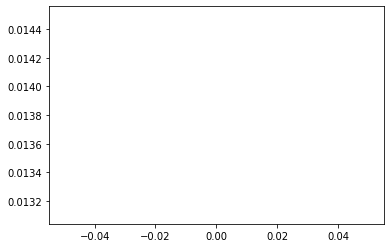

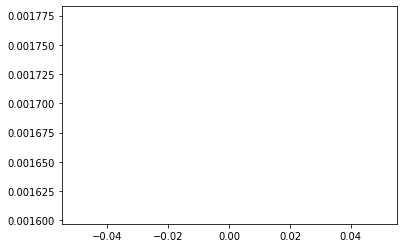

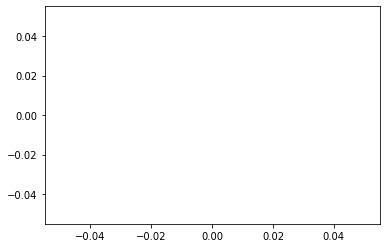

In [ ]:
test = train[0:40000]
f = 'ProductCD'
d = Chi_test(test,f)
a = IG(test,f,'Entropy')
b = IG(test,f,'Gini')
c = IG(test,f,'MisEr')
fig, ax = plt.subplots()
plt.plot(a)
fig, ax = plt.subplots()
plt.plot(b)
fig, ax = plt.subplots()
plt.plot(c)
print (a,b,c,d)

In [104]:
a = Chi_test(test,'C1',2)
a

2.7437641723356005 3.841458820694124


0

In [99]:
test = pd.DataFrame(columns = ['C1','isFraud'])
for i in range(6):
    test.loc[i,'C1'] = 1
test.loc[6,'C1'] = 2
test.loc[7,'C1'] = 3
test.loc[8,'C1'] = 4
test.loc[9,'C1'] = 9
test.iloc[0:10,1] = 0

test.loc[2,'isFraud'] = 1
test.loc[8,'isFraud'] = 1
test.loc[7,'isFraud'] = 1
test = test.sample(frac = 1)
print (test)

  C1 isFraud
1  1       0
4  1       0
7  3       1
3  1       0
6  2       0
8  4       1
9  9       0
0  1       0
2  1       1
5  1       0


In [205]:
a[1]

2.0

In [163]:
test[test[Target] == 1]

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
37,38,C,16136,204.0,185.0,visa,138.0,debit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1
54,55,W,7815,161.0,150.0,mastercard,117.0,debit,203.0,87.0,...,3.0,0.0,0.0,1.0,0.0,3.0,0.0,4.0,1.0,1
65,66,C,3213,459.0,185.0,visa,226.0,credit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
90,91,W,13780,298.0,150.0,visa,226.0,debit,441.0,87.0,...,2.0,0.0,0.0,2.0,0.0,2.0,1.0,9.0,2.0,1
99,100,W,6357,480.0,150.0,mastercard,219.0,credit,485.0,87.0,...,59.0,0.0,0.0,54.0,0.0,50.0,0.0,442.0,73.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,3839,W,17188,321.0,150.0,visa,226.0,debit,122.0,87.0,...,2.0,0.0,0.0,9.0,0.0,3.0,0.0,20.0,4.0,1
3860,3861,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,...,2.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,1.0,1
3862,3863,C,5812,408.0,185.0,mastercard,224.0,debit,NotFound,NotFound,...,5.0,5.0,11.0,0.0,6.0,11.0,11.0,2.0,2.0,1
3914,3915,W,2947,380.0,150.0,visa,226.0,debit,315.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1


In [89]:
a_fft = np.fft.fft(a)
conv_array = np.zeros(a_fft.shape)
conv_array[0:5] = 1/10
conv_array[-5:] = 1/10
conv_array[0:5]

array([0.1, 0.1, 0.1, 0.1, 0.1])

(0.0, 100.0)

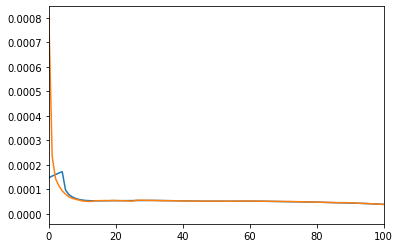

In [120]:
a_fft = np.fft.fft(a)
conv_array = np.zeros(a_fft.shape)
conv_array[0:5] = 1/10
conv_array[-5:] = 1/10
conv_fft = np.fft.fft(conv_array)
a_conv = np.fft.ifft(conv_fft * a_fft).real
a_fft[int(a_fft.shape[0]/10):] = 0
a_ifft = np.abs(np.fft.ifft(a_fft))
#plt.plot(a_ifft)
plt.plot(a_conv)
plt.plot(a)
plt.xlim(0,100)


<font color = red> **Experiment1: </font>** with only 100 random rows

Load data

In [ ]:
# shuffle the train data
train = train.sample(frac = 1)
Exp1_train = train[0:100]
Exp1_train.tail()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
3475,3476,W,15497,490.0,150.0,visa,226.0,debit,220.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
3096,3097,W,17188,321.0,150.0,visa,226.0,debit,310.0,87.0,...,5.0,0.0,0.0,4.0,0.0,5.0,0.0,29.0,7.0,0
41412,41413,W,12389,532.0,150.0,mastercard,137.0,credit,485.0,87.0,...,17.0,0.0,0.0,12.0,0.0,11.0,0.0,77.0,18.0,0
252732,252733,W,1214,174.0,150.0,visa,226.0,credit,181.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,0
429720,429721,C,11436,555.0,150.0,visa,226.0,credit,NotFound,NotFound,...,16.0,16.0,33.0,0.0,17.0,20.0,20.0,2.0,2.0,1


Gini index for the Root node

In [ ]:
for i in Columns:
  if i in Categoric_features:

  if i in Numeric_features:




array(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'TransactionDT', 'TransactionAmt', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14', 'isFraud'], dtype=object)

<font color = 'green'><b> -------- Leo end --------- </b></font>

<font color = 'Blue'><b> -------- Behnoud start -------- </b></font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
train=pd.read_csv('sample_data/train.csv')
test=pd.read_csv('sample_data/test.csv')
train

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/train.csv'

In [ ]:
def IG_Numeric(Input_Dataframe, Split_feature, IG_methods): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = len(Fraud_arr[Fraud_arr == 1])/length
  P_notF = 1-P_isF
  Gini_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
  Gini_leaves = [] #Gini index of each leaves
  Prop_leaves = [] #Propotion of each leaves
  print ('Pass line 10')
  if Split_feature in Numeric_features:
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    if IG_methods == 'Gini':
      print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Gini_leaves.append(1 - np.power(Sub_P_isF,2)  - np.power(Sub_P_notF,2))
        Prop_leaves.append(Sub_len/length)
  Gini_root = np.array(Gini_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature = Gini_root - np.matmul(Gini_leaves,Prop_leaves.T)

  return IG_feature

In [ ]:
test = train[0:10]
print(IG_Numeric(test,'card4','Gini'))
test

Pass line 3
Pass line 10
0.31999999999999984


,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
278213,278214,W,8691,599.0,150.0,visa,166.0,debit,226.0,87.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,10.0,3.0,0
96508,96509,C,2650,142.0,185.0,mastercard,224.0,debit,NotFound,NotFound,...,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0
396545,396546,W,14259,111.0,150.0,visa,226.0,debit,330.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1
366700,366701,W,7919,194.0,150.0,mastercard,202.0,debit,330.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
330372,330373,C,2256,545.0,185.0,visa,226.0,credit,NotFound,NotFound,...,1.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,0
344300,344301,W,12501,490.0,150.0,visa,226.0,debit,204.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
9200,9201,W,7676,512.0,150.0,visa,226.0,debit,220.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
404371,404372,C,16346,324.0,185.0,visa,226.0,credit,NotFound,NotFound,...,2.0,2.0,2.0,0.0,1.0,4.0,4.0,1.0,0.0,1
291138,291139,W,15811,452.0,150.0,mastercard,195.0,debit,264.0,87.0,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,7.0,3.0,0
246079,246080,W,9500,321.0,150.0,visa,226.0,debit,204.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
